# Import libraries

In [41]:
import pandas as pd
import plotnine as pn
import pingouin as pg

pn.theme_set(pn.theme_minimal())

print("Pandas: %s"%pd.__version__)
print("Plotnine: %s"%pn.__version__)
print("Pingouin: %s"%pg.__version__)

Pandas: 2.2.3
Plotnine: 0.14.5
Pingouin: 0.5.5


# Utility functions

In [42]:
def precs_and_recs(data, ref, algorithms):
    grouped = data.groupby(["path","type"])["line"].apply(set)
    values = []
    for path in set([path for (path, _) in grouped.keys()]):
        ref_lines = grouped[path][ref]
        for alg in algorithms:
            if grouped[path].get(alg) is None:
                values.append([path, alg, 0.0, 0.0])
                continue

            alg_lines = grouped[path][alg]
            common_lines = ref_lines & alg_lines
            recall = len(common_lines) / len(ref_lines)
            precision = len(common_lines) / len(alg_lines)
            values.append([path, alg, precision, recall])

    return pd.DataFrame(values, columns=['path', 'algorithm', 'precision', 'recall'])


# Load data

In [43]:
data = pd.read_csv('results.csv')
results = precs_and_recs(data, 'human', ['bigram', 'lcs', 'seed', 'keyword'])
results['f1-score'] = 2 * ((results['precision'] * results['recall']) / (results['precision'] + results['recall']))
legends = ['2kdiff (bigram)', 'keyword', 'lcs-diff', 'cidiff']

# Generate plots

/Users/falleri/work/code/cidiff-analysis/.venv/lib/python3.13/site-packages/plotnine/ggplot.py:615: PlotnineWarning: Saving 4 x 3 in image.
/Users/falleri/work/code/cidiff-analysis/.venv/lib/python3.13/site-packages/plotnine/ggplot.py:616: PlotnineWarning: Filename: img/precisions.pdf


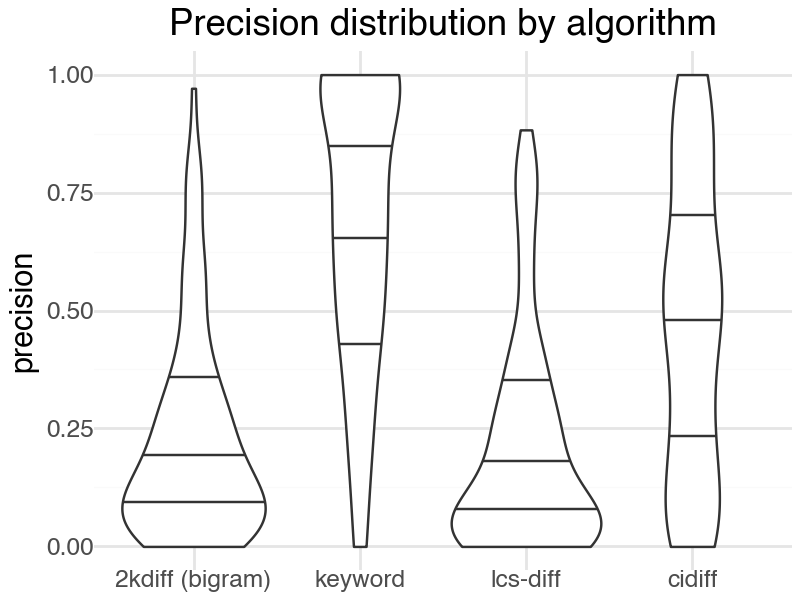

In [44]:
plot = pn.ggplot(results, pn.aes(x='algorithm', y='precision')) + pn.geom_violin(scale="count", draw_quantiles=[0.25, 0.5, 0.75]) + pn.scale_x_discrete(labels=legends) + pn.xlab('') + pn.ggtitle("Precision distribution by algorithm") + pn.theme(figure_size=(4,3))
plot.save('img/precisions.pdf')
plot

/Users/falleri/work/code/cidiff-analysis/.venv/lib/python3.13/site-packages/plotnine/ggplot.py:615: PlotnineWarning: Saving 4 x 3 in image.
/Users/falleri/work/code/cidiff-analysis/.venv/lib/python3.13/site-packages/plotnine/ggplot.py:616: PlotnineWarning: Filename: img/recalls.pdf


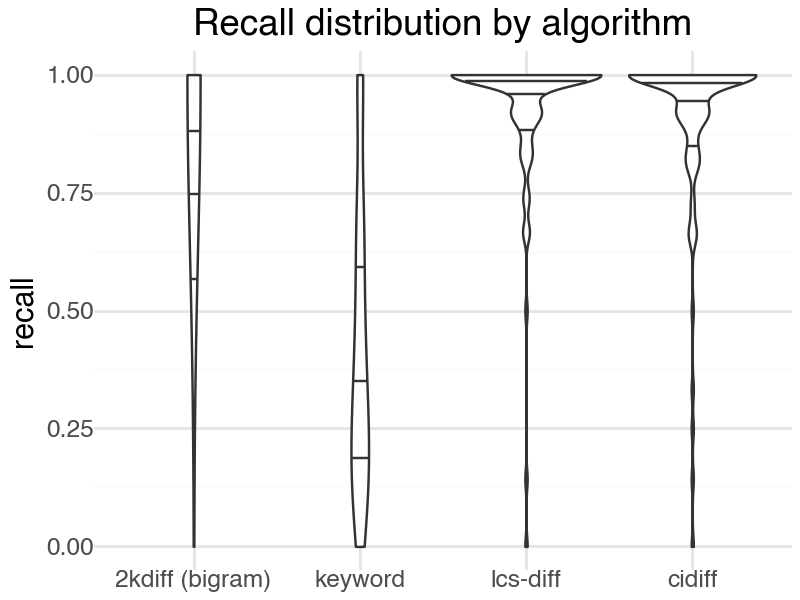

In [45]:
plot = pn.ggplot(results, pn.aes(x='algorithm', y='recall')) + pn.geom_violin(scale="area", draw_quantiles=[0.25, 0.5, 0.75]) + pn.scale_x_discrete(labels=legends) + pn.xlab('') + pn.ggtitle("Recall distribution by algorithm") + pn.theme(figure_size=(4,3))
plot.save('img/recalls.pdf')
plot

/Users/falleri/work/code/cidiff-analysis/.venv/lib/python3.13/site-packages/plotnine/ggplot.py:615: PlotnineWarning: Saving 4 x 3 in image.
/Users/falleri/work/code/cidiff-analysis/.venv/lib/python3.13/site-packages/plotnine/ggplot.py:616: PlotnineWarning: Filename: img/f1-scores.pdf
/Users/falleri/work/code/cidiff-analysis/.venv/lib/python3.13/site-packages/plotnine/layer.py:284: PlotnineWarning: stat_ydensity : Removed 7 rows containing non-finite values.
/Users/falleri/work/code/cidiff-analysis/.venv/lib/python3.13/site-packages/plotnine/layer.py:284: PlotnineWarning: stat_ydensity : Removed 7 rows containing non-finite values.


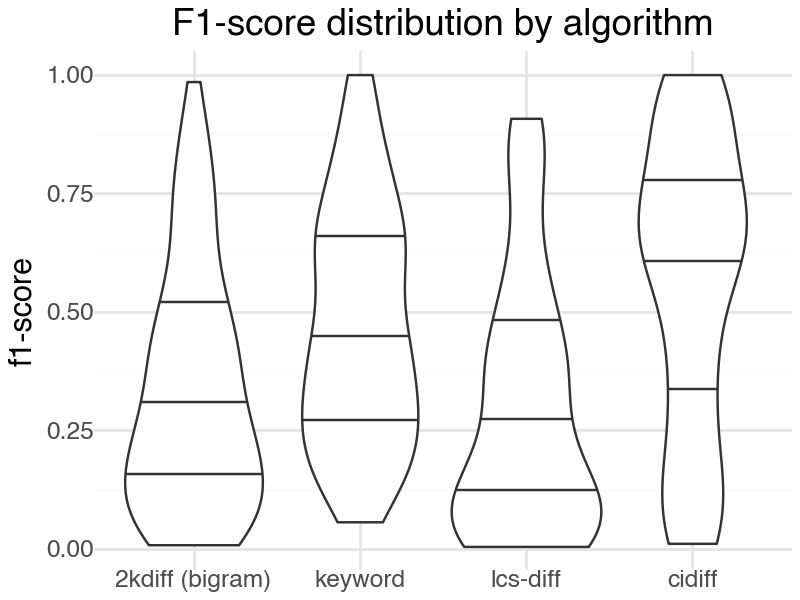

In [46]:
plot = pn.ggplot(results, pn.aes(x='algorithm', y='f1-score')) + pn.geom_violin(scale="area", draw_quantiles=[0.25, 0.5, 0.75]) + pn.scale_x_discrete(labels=legends) + pn.xlab('') + pn.ggtitle("F1-score distribution by algorithm") + pn.theme(figure_size=(4,3))
plot.save('img/f1-scores.pdf')
plot